# QA問題（FacebookのBABIデータを用いて）

https://github.com/keras-team/keras/blob/master/examples/babi_memnn.py10_cnn.py

End-to-Endメモリネットワーク

<pre>
Trains a memory network on the bAbI dataset.
References:
- Jason Weston, Antoine Bordes, Sumit Chopra, Tomas Mikolov, Alexander M. Rush,
  "Towards AI-Complete Question Answering: A Set of Prerequisite Toy Tasks",
  http://arxiv.org/abs/1502.05698
- Sainbayar Sukhbaatar, Arthur Szlam, Jason Weston, Rob Fergus,
  "End-To-End Memory Networks",
  http://arxiv.org/abs/1503.08895
Reaches 98.6% accuracy on task 'single_supporting_fact_10k' after 120 epochs.
Time per epoch: 3s on CPU (core i7).
</pre>

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3  #30%
session = tf.Session(config=config)
import keras
from keras import backend as K
K.set_session(session) 


Using TensorFlow backend.


In [2]:
from keras.models import Sequential, Model
from keras.layers.embeddings import Embedding
from keras.layers import Input, Activation, Dense, Permute, Dropout, add, dot, concatenate
from keras.layers import LSTM # GPUがない場合, CuDNNLSTM
from keras.utils.data_utils import get_file
from keras.preprocessing.sequence import pad_sequences
from functools import reduce
import tarfile
import numpy as np
import re


In [3]:
def tokenize(sent):
    '''Return the tokens of a sentence including punctuation.
    >>> tokenize('Bob dropped the apple. Where is the apple?')
    ['Bob', 'dropped', 'the', 'apple', '.', 'Where', 'is', 'the', 'apple', '?']
    '''
    return [x.strip() for x in re.split('(\W+)?', sent) if x.strip()]


In [4]:
sample1 = "I love you more than anything."
print (tokenize(sample1))


['I', 'love', 'you', 'more', 'than', 'anything', '.']


In [5]:
def parse_stories(lines, only_supporting=False):
    '''Parse stories provided in the bAbi tasks format
    If only_supporting is true, only the sentences
    that support the answer are kept.
    '''
    data = []
    story = []
    for line in lines:
        line = line.decode('utf-8').strip()
        nid, line = line.split(' ', 1)
        nid = int(nid)
        if nid == 1:
            story = []
        if '\t' in line:
            q, a, supporting = line.split('\t')
            q = tokenize(q)
            substory = None
            if only_supporting:
                # Only select the related substory
                supporting = map(int, supporting.split())
                substory = [story[i - 1] for i in supporting]
            else:
                # Provide all the substories
                substory = [x for x in story if x]
            data.append((substory, q, a))
            story.append('')
        else:
            sent = tokenize(line)
            story.append(sent)
    return data


In [6]:
def get_stories(f, only_supporting=False, max_length=None):
    '''Given a file name, read the file,
    retrieve the stories,
    and then convert the sentences into a single story.
    If max_length is supplied,
    any stories longer than max_length tokens will be discarded.
    '''
    data = parse_stories(f.readlines(), only_supporting=only_supporting)
    flatten = lambda data: reduce(lambda x, y: x + y, data)
    data = [(flatten(story), q, answer) 
            for story, q, answer in data if not max_length or len(flatten(story)) < max_length]
    return data


In [7]:
def vectorize_stories(data):
    inputs, queries, answers = [], [], []
    for story, query, answer in data:
        inputs.append([word_idx[w] for w in story])
        queries.append([word_idx[w] for w in query])
        answers.append(word_idx[answer])
    return (pad_sequences(inputs, maxlen=story_maxlen),
            pad_sequences(queries, maxlen=query_maxlen),
            np.array(answers))
  

In [8]:
try:
    path = get_file('babi-tasks-v1-2.tar.gz', 
                    origin='https://s3.amazonaws.com/text-datasets/babi_tasks_1-20_v1-2.tar.gz')
except:
    print('Error downloading dataset, please download it manually:\n'
          '$ wget http://www.thespermwhale.com/jaseweston/babi/tasks_1-20_v1-2.tar.gz\n'
          '$ mv tasks_1-20_v1-2.tar.gz ~/.keras/datasets/babi-tasks-v1-2.tar.gz')
    raise

11747328/11745123 [==============================] - 8s 1us/step


In [9]:
challenges = {
    # QA1 with 10,000 samples
    'single_supporting_fact_10k': 'tasks_1-20_v1-2/en-10k/qa1_single-supporting-fact_{}.txt',
    # QA2 with 10,000 samples
    'two_supporting_facts_10k': 'tasks_1-20_v1-2/en-10k/qa2_two-supporting-facts_{}.txt',
}
challenge_type = 'single_supporting_fact_10k'
challenge = challenges[challenge_type]


In [10]:
print('Extracting stories for the challenge:', challenge_type)
with tarfile.open(path) as tar:
    train_stories = get_stories(tar.extractfile(challenge.format('train')))
    test_stories = get_stories(tar.extractfile(challenge.format('test')))

print("training data: stories = ", type(train_stories), len(train_stories))# , train_stories)
print("1st story = ",train_stories[0])
print("2nd story = ",train_stories[1])
print("4th story = ",train_stories[3])
print("last story = ",train_stories[9999])

Extracting stories for the challenge: single_supporting_fact_10k
training data: stories =  <class 'list'> 10000
1st story =  (['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
2nd story =  (['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.', 'Sandra', 'moved', 'to', 'the', 'garden', '.'], ['Where', 'is', 'Daniel', '?'], 'hallway')
4th story =  (['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.', 'Daniel', 'went', 'back', 'to', 'the', 'hallway', '.', 'Sandra', 'moved', 'to', 'the', 'garden', '.', 'John', 'moved', 'to', 'the', 'office', '.', 'Sandra', 'journeyed', 'to', 'the', 'bathroom', '.', 'Mary', 'moved', 'to', 'the', 'hallway', '.', 'Daniel', 'travelled', 'to', 'the', 'office', '.'], ['Where', 'is', 'Daniel', '?'], 'office')
last story =  (['John', 'moved', 'to',

In [11]:
vocab = set()
for story, q, answer in train_stories + test_stories:
    vocab |= set(story + q + [answer])
vocab = sorted(vocab)
print(vocab)

# Reserve 0 for masking via pad_sequences
vocab_size = len(vocab) + 1
story_maxlen = max(map(len, (x for x, _, _ in train_stories + test_stories)))
query_maxlen = max(map(len, (x for _, x, _ in train_stories + test_stories)))

print('-')
print('Vocab size:', vocab_size, 'unique words')
print('Story max length:', story_maxlen, 'words')
print('Query max length:', query_maxlen, 'words')
print('Number of training stories:', len(train_stories))
print('Number of test stories:', len(test_stories))
print('-')
print('Here\'s what a "story" tuple looks like (input, query, answer):')
print(train_stories[0])
print('-')
print('Vectorizing the word sequences...')

['.', '?', 'Daniel', 'John', 'Mary', 'Sandra', 'Where', 'back', 'bathroom', 'bedroom', 'garden', 'hallway', 'is', 'journeyed', 'kitchen', 'moved', 'office', 'the', 'to', 'travelled', 'went']
-
Vocab size: 22 unique words
Story max length: 68 words
Query max length: 4 words
Number of training stories: 10000
Number of test stories: 1000
-
Here's what a "story" tuple looks like (input, query, answer):
(['Mary', 'moved', 'to', 'the', 'bathroom', '.', 'John', 'went', 'to', 'the', 'hallway', '.'], ['Where', 'is', 'Mary', '?'], 'bathroom')
-
Vectorizing the word sequences...


In [12]:
word_idx = dict((c, i + 1) for i, c in enumerate(vocab))
inputs_train, queries_train, answers_train = vectorize_stories(train_stories)
inputs_test, queries_test, answers_test = vectorize_stories(test_stories)

print('-')
print('inputs: integer tensor of shape (samples, max_length)')
print('inputs_train shape:', inputs_train.shape)
print('inputs_test shape:', inputs_test.shape)
print('-')
print('queries: integer tensor of shape (samples, max_length)')
print('queries_train shape:', queries_train.shape)
print('queries_test shape:', queries_test.shape)
print('-')
print('answers: binary (1 or 0) tensor of shape (samples, vocab_size)')
print('answers_train shape:', answers_train.shape)
print('answers_test shape:', answers_test.shape)
print('-')
print('Compiling...')

-
inputs: integer tensor of shape (samples, max_length)
inputs_train shape: (10000, 68)
inputs_test shape: (1000, 68)
-
queries: integer tensor of shape (samples, max_length)
queries_train shape: (10000, 4)
queries_test shape: (1000, 4)
-
answers: binary (1 or 0) tensor of shape (samples, vocab_size)
answers_train shape: (10000,)
answers_test shape: (1000,)
-
Compiling...


In [13]:
# placeholders
input_sequence = Input((story_maxlen,))
question = Input((query_maxlen,))
print(type(input_sequence))
print(input_sequence)


<class 'tensorflow.python.framework.ops.Tensor'>
Tensor("input_1:0", shape=(?, 68), dtype=float32)


In [14]:
# encoders
# embed the input sequence into a sequence of vectors
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=64))
input_encoder_m.add(Dropout(0.3))
# output: (samples, story_maxlen, embedding_dim)

print("input_encoder_m: ",input_encoder_m)
input_encoder_m.summary()

input_encoder_m:  <keras.models.Sequential object at 0x00000176503893C8>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 64)          1408      
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 64)          0         
Total params: 1,408
Trainable params: 1,408
Non-trainable params: 0
_________________________________________________________________


In [15]:
# embed the input into a sequence of vectors of size query_maxlen
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=query_maxlen))
input_encoder_c.add(Dropout(0.3))
# output: (samples, story_maxlen, query_maxlen)

print("input_encoder_c: ",input_encoder_c)
input_encoder_c.summary()

input_encoder_c:  <keras.models.Sequential object at 0x0000017650389358>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 4)           88        
_________________________________________________________________
dropout_2 (Dropout)          (None, None, 4)           0         
Total params: 88
Trainable params: 88
Non-trainable params: 0
_________________________________________________________________


In [16]:
# embed the question into a sequence of vectors
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=64,
                               input_length=query_maxlen))
question_encoder.add(Dropout(0.3))
# output: (samples, query_maxlen, embedding_dim)

print("question_encoder: ",question_encoder)
question_encoder.summary()

question_encoder:  <keras.models.Sequential object at 0x0000017652624B00>
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 4, 64)             1408      
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 64)             0         
Total params: 1,408
Trainable params: 1,408
Non-trainable params: 0
_________________________________________________________________


In [17]:
# encode input sequence and questions (which are indices)
# to sequences of dense vectors
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)
print("input_sequence = ",input_sequence)
print("question_encoded = ",question_encoded)
print("question = ",question)
print("input_encoded_m = ",input_encoded_m)
print("input_encoded_c = ",input_encoded_c)

input_sequence =  Tensor("input_1:0", shape=(?, 68), dtype=float32)
question_encoded =  Tensor("sequential_3/dropout_3/cond/Merge:0", shape=(?, 4, 64), dtype=float32)
question =  Tensor("input_2:0", shape=(?, 4), dtype=float32)
input_encoded_m =  Tensor("sequential_1/dropout_1/cond/Merge:0", shape=(?, 68, 64), dtype=float32)
input_encoded_c =  Tensor("sequential_2/dropout_2/cond/Merge:0", shape=(?, 68, 4), dtype=float32)


In [18]:
# compute a 'match' between the first input vector sequence
# and the question vector sequence
# shape: `(samples, story_maxlen, query_maxlen)`
match = dot([input_encoded_m, question_encoded], axes=(2, 2))
match2 = match
match = Activation('softmax')(match)

print("match2(dot):",match2)
print("match(Activation):",match)

match2(dot): Tensor("dot_1/MatMul:0", shape=(?, 68, 4), dtype=float32)
match(Activation): Tensor("activation_1/truediv:0", shape=(?, 68, 4), dtype=float32)


In [19]:
# add the match matrix with the second input vector sequence
response = add([match, input_encoded_c])  # (samples, story_maxlen, query_maxlen)
response2 = response
response = Permute((2, 1))(response)  # (samples, query_maxlen, story_maxlen)

print("response2(add):",response2)
print("response(Permute):",response)

response2(add): Tensor("add_1/add:0", shape=(?, 68, 4), dtype=float32)
response(Permute): Tensor("permute_1/transpose:0", shape=(?, 4, 68), dtype=float32)


In [20]:
# concatenate the match matrix with the question vector sequence
answer = concatenate([response, question_encoded])
print("answer(concatenate):",answer)

answer(concatenate): Tensor("concatenate_1/concat:0", shape=(?, 4, 132), dtype=float32)


In [21]:
# the original paper uses a matrix multiplication for this reduction step.
# we choose to use a RNN instead.
# GPUがあればCuDNNLSTM, なければLSTM
answer = LSTM(32)(answer)  # (samples, 32)
print("answer(LSTM(32))",answer)

# one regularization layer -- more would probably be needed.
answer = Dropout(0.3)(answer)
answer1 = answer
print("answer1(Dropout)",answer1)

answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
answer2 = answer
print("answer2(Dense)",answer2)

# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)
print("answer(Activation)",answer)

# build the final model
model = Model([input_sequence, question], answer)

model.summary()

model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

answer(LSTM(32)) Tensor("lstm_1/TensorArrayReadV3:0", shape=(?, 32), dtype=float32)
answer1(Dropout) Tensor("dropout_4/cond/Merge:0", shape=(?, 32), dtype=float32)
answer2(Dense) Tensor("dense_1/BiasAdd:0", shape=(?, 22), dtype=float32)
answer(Activation) Tensor("activation_2/Softmax:0", shape=(?, 22), dtype=float32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 68)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 4)            0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       multiple             1408        input_1[0][0]         

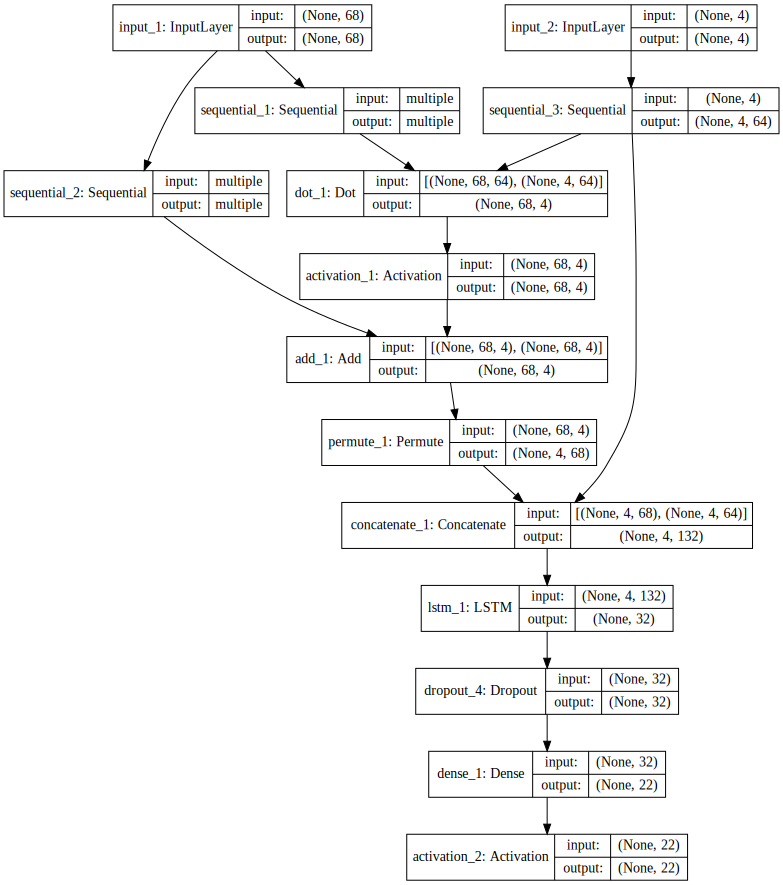

In [22]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, to_file='images/Python-BABI.jpg')
plot_model(model, show_shapes=True, to_file='pdf/Python-BABI.pdf')

SVG(model_to_dot(model,show_shapes=True).create(prog='dot', format='svg'))

In [23]:
# train
history = model.fit([inputs_train, queries_train], answers_train,  
                    batch_size=32,
                    epochs=120,
                    validation_data=([inputs_test, queries_test], answers_test))

Train on 10000 samples, validate on 1000 samples
Epoch 1/120
10000/10000 [==============================] - 3s 302us/step - loss: 1.9419 - acc: 0.1708 - val_loss: 1.7823 - val_acc: 0.2330
Epoch 2/120
10000/10000 [==============================] - 2s 223us/step - loss: 1.7358 - acc: 0.2341 - val_loss: 1.6536 - val_acc: 0.2930
Epoch 3/120
10000/10000 [==============================] - 2s 223us/step - loss: 1.6677 - acc: 0.2753 - val_loss: 1.6459 - val_acc: 0.3080
Epoch 4/120
10000/10000 [==============================] - 2s 223us/step - loss: 1.6368 - acc: 0.3104 - val_loss: 1.6479 - val_acc: 0.3150
Epoch 5/120
10000/10000 [==============================] - 2s 224us/step - loss: 1.5563 - acc: 0.3720 - val_loss: 1.5597 - val_acc: 0.3870
Epoch 6/120
10000/10000 [==============================] - 2s 225us/step - loss: 1.5077 - acc: 0.4022 - val_loss: 1.5059 - val_acc: 0.4180
Epoch 7/120
10000/10000 [==============================] - 2s 225us/step - loss: 1.4798 - acc: 0.4154 - val_loss: 1.4

10000/10000 [==============================] - 2s 222us/step - loss: 0.5105 - acc: 0.8001 - val_loss: 0.5808 - val_acc: 0.7460
Epoch 60/120
10000/10000 [==============================] - 2s 224us/step - loss: 0.4846 - acc: 0.8082 - val_loss: 0.5303 - val_acc: 0.7660
Epoch 61/120
10000/10000 [==============================] - 2s 231us/step - loss: 0.4566 - acc: 0.8233 - val_loss: 0.5091 - val_acc: 0.7900
Epoch 62/120
10000/10000 [==============================] - 2s 233us/step - loss: 0.4328 - acc: 0.8349 - val_loss: 0.4869 - val_acc: 0.8000
Epoch 63/120
10000/10000 [==============================] - 2s 235us/step - loss: 0.4106 - acc: 0.8437 - val_loss: 0.4929 - val_acc: 0.7940
Epoch 64/120
10000/10000 [==============================] - 2s 228us/step - loss: 0.3869 - acc: 0.8530 - val_loss: 0.4421 - val_acc: 0.8340
Epoch 65/120
10000/10000 [==============================] - 2s 237us/step - loss: 0.3765 - acc: 0.8574 - val_loss: 0.4417 - val_acc: 0.8360
Epoch 66/120
10000/10000 [=======

10000/10000 [==============================] - 2s 223us/step - loss: 0.0878 - acc: 0.9691 - val_loss: 0.1879 - val_acc: 0.9360
Epoch 118/120
10000/10000 [==============================] - 3s 284us/step - loss: 0.0799 - acc: 0.9712 - val_loss: 0.2022 - val_acc: 0.9360
Epoch 119/120
10000/10000 [==============================] - 3s 268us/step - loss: 0.0797 - acc: 0.9731 - val_loss: 0.1914 - val_acc: 0.9400
Epoch 120/120
10000/10000 [==============================] - 3s 260us/step - loss: 0.0788 - acc: 0.9724 - val_loss: 0.1871 - val_acc: 0.9390


In [24]:
model.save('h5/Python-BABI.h5') # h5 (HDF5)
model.save_weights("h5/Python-BABI-weights.h5")

In [25]:
import pickle
with open('pkl/Python-BABI.pkl', 'wb') as h_file:
    pickle.dump(history.history, h_file) # save history


In [26]:
pred = model.predict([inputs_test, queries_test])

# 結果を表示
print("予測:\n", pred)

予測:
 [[7.1633130e-18 8.3096836e-18 7.0580700e-18 ... 6.2768347e-18
  6.7472258e-18 7.7297447e-18]
 [6.8020293e-17 7.3366176e-17 7.2987373e-17 ... 7.5734063e-17
  6.2326610e-17 8.4002825e-17]
 [1.7963482e-18 1.5542540e-18 1.7585086e-18 ... 2.1371584e-18
  1.9459718e-18 2.6938723e-18]
 ...
 [2.1204213e-18 2.3771971e-18 2.1515383e-18 ... 2.4739599e-18
  2.0477247e-18 2.1310602e-18]
 [4.5856230e-17 6.1824816e-17 5.5343353e-17 ... 6.1435723e-17
  4.6705933e-17 7.1860991e-17]
 [4.3104738e-09 4.6355999e-09 4.5374580e-09 ... 4.4574087e-09
  4.3227661e-09 4.6778510e-09]]


In [27]:
# Evaluate model with test data set and share sample prediction results
score = model.evaluate([inputs_test, queries_test], answers_test, verbose=0)
print('テストデータの損失:', score[0])
print('テストデータの精度:', score[1])


テストデータの損失: 0.18706446186453105
テストデータの精度: 0.939


In [28]:
# Matplotlibのフォントの制御（大きさや種類）
%matplotlib inline
import numpy as np # Numpy
import matplotlib
import matplotlib.pyplot as plt # 描画ライブラリ
print (matplotlib.rcParams.get('font.family'))
import matplotlib.font_manager as fm
import matplotlib.patheffects as path_effects

font_prop = fm.FontProperties()  
font_prop.set_style('normal')
font_prop.set_weight('light')
font_prop.set_size('12')

fp2 = font_prop.copy()# フォントプロパティ(FP)をコピー
fp2.set_size('20')# フォントプロパティ(FP)をコピー
fp2.set_family('serif')# フォントはSerif(明朝体など）に設定

['sans-serif']


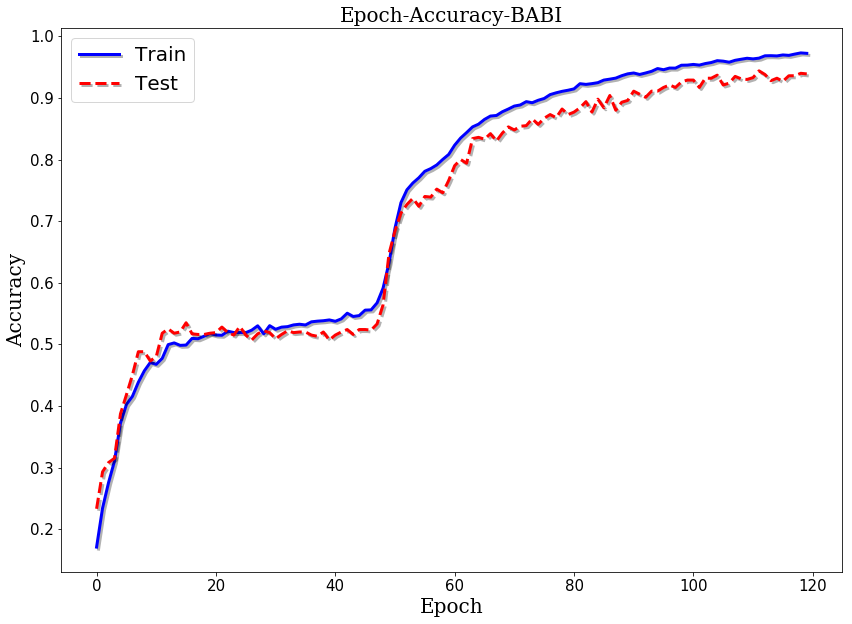

In [29]:
% matplotlib inline
import matplotlib.pyplot as plt

# 精度グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(history.history['acc'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_acc'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=15)
plt.title('Epoch-Accuracy-BABI',fontsize=25,font_properties=fp2)
plt.ylabel('Accuracy',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Train', 'Test'], loc='best', fontsize=20)

plt.savefig('pdf/Epoch-Accuracy-BABI.pdf')
plt.show()

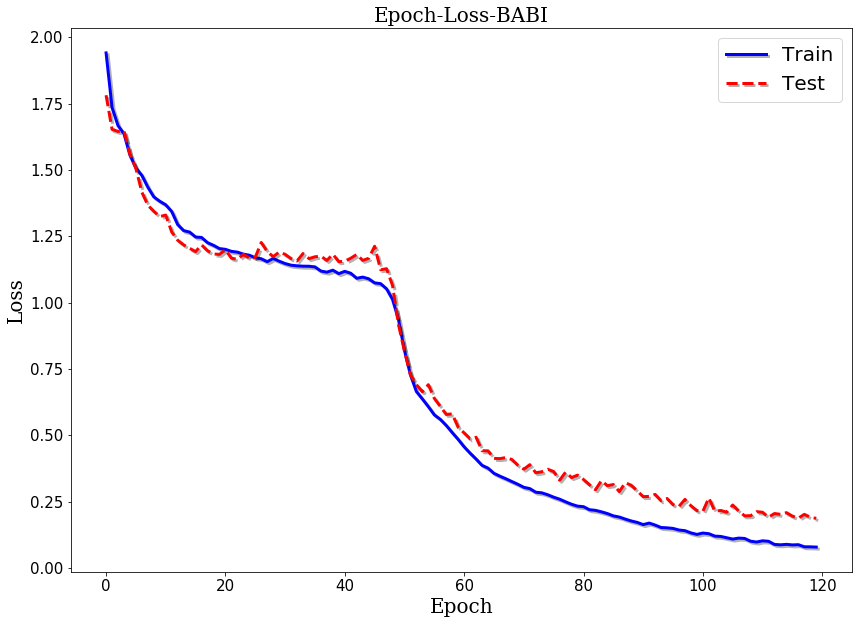

In [30]:
# 損失グラフの描画　% matplotlib inline
plt.figure(figsize=(14,10))

plt.plot(history.history['loss'], 
         color='b', 
         linestyle='-', 
         linewidth=3, 
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])
plt.plot(history.history['val_loss'], 
         color='r', 
         linestyle='--',
         linewidth=3,
         path_effects=[path_effects.SimpleLineShadow(),
                       path_effects.Normal()])

plt.tick_params(labelsize=15)
plt.title('Epoch-Loss-BABI',fontsize=25,font_properties=fp2)
plt.ylabel('Loss',fontsize=20,font_properties=fp2)
plt.xlabel('Epoch',fontsize=20,font_properties=fp2)
plt.legend(['Train', 'Test'], loc='best', fontsize=20)

plt.savefig('pdf/Epoch-Loss-BABI.pdf')
plt.show()

In [31]:
from sklearn.metrics import classification_report,confusion_matrix
y_pred = model.predict([inputs_test, queries_test])
print(y_pred)


[[7.1633130e-18 8.3096836e-18 7.0580700e-18 ... 6.2768347e-18
  6.7472258e-18 7.7297447e-18]
 [6.8020293e-17 7.3366176e-17 7.2987373e-17 ... 7.5734063e-17
  6.2326610e-17 8.4002825e-17]
 [1.7963482e-18 1.5542540e-18 1.7585086e-18 ... 2.1371584e-18
  1.9459718e-18 2.6938723e-18]
 ...
 [2.1204213e-18 2.3771971e-18 2.1515383e-18 ... 2.4739599e-18
  2.0477247e-18 2.1310602e-18]
 [4.5856230e-17 6.1824816e-17 5.5343353e-17 ... 6.1435723e-17
  4.6705933e-17 7.1860991e-17]
 [4.3104738e-09 4.6355999e-09 4.5374580e-09 ... 4.4574087e-09
  4.3227661e-09 4.6778510e-09]]


In [32]:
# 混合行列の描画関数の定義
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import pylab
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Oranges):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=25)
    cb = plt.colorbar()
    cb.ax.tick_params(labelsize=15)
    # plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center", fontsize=15,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=20)
    plt.xlabel('Predicted label',fontsize=20)

In [33]:
# 未知データのクラスの予測
pred_classes = np.argmax(pred, axis=1)
print(pred_classes)
print(pred_classes.shape)

[12  9 15 12 15 12 11 12 17 17 15 11 17 10 17 15 11 15 15 17 12 17 17 12
 10 10 10 15 15 17 12 17 15 15  9 17  9 11 15 10  9 11 10 12 11 15 12  9
 17 10 10 17 11 11 15 10 15 12 11 12 12 17  9 11 11 15 15  9 17 15 11 12
 11 10  9 15 15 15 12 17 11  9 10 11 17 11 11 12 15 15  9  9 12  9  9 15
 15 15 10 10 10  9 17 11 11 12 10  9 17 10  9  9 15 12 15 11 17 15  9 17
 10  9 17 12 10 17 11 11 11  9 11 11  9 11 15  9 17 15  9  9 17 12 12 17
 10 15 15 15 15 15 11 11  9 17 10  9 11 10 17 12 10 10 10 11  9 11 11 11
 15 10 17 17 11  9  9 17 15 10 17 17 12 12 12 12 10  9 17 11 15 17 12 15
 11 12 17 11 17 15  9 10 12 17 12 10 12  9 15 12  9  9  9 10 12 10  9 10
  9 12 12  9  9 12 15 17 10 17 12 11  9  9 17 11 12 17 12 10 10  9 10 11
 12 15 11 11 15 15 11 11 17 11 10 17  9  9 10 10 17 17 15 11 11 17 12 17
 17  9 11 10  9 10 15 17 17 15  9 17 15 12 17  9  9 11 17 17 11 17  9 17
 11  9 15 15 10 15 15 11 11 12 12  9  9 15 15 17 17 11  9 17  9 15 11 11
 17 10 12 17 10 17 15 11 11 15 15 11 11  9 10 11 11

In [34]:
new_story = '''Daniel went to the office. Mary moved to the kitchen.
        Daniel journeyed to the hallway. Sandra travelled to the bedroom.
        '''
new_query = 'Where is Daniel?'
s1 = tokenize(new_story)
q1 = tokenize(new_query)
print(s1)
print(q1)
mylist = ([s1,q1])
print(mylist)

['Daniel', 'went', 'to', 'the', 'office', '.', 'Mary', 'moved', 'to', 'the', 'kitchen', '.', 'Daniel', 'journeyed', 'to', 'the', 'hallway', '.', 'Sandra', 'travelled', 'to', 'the', 'bedroom', '.']
['Where', 'is', 'Daniel', '?']
[['Daniel', 'went', 'to', 'the', 'office', '.', 'Mary', 'moved', 'to', 'the', 'kitchen', '.', 'Daniel', 'journeyed', 'to', 'the', 'hallway', '.', 'Sandra', 'travelled', 'to', 'the', 'bedroom', '.'], ['Where', 'is', 'Daniel', '?']]


In [35]:
def vectorize_story_and_query(data, word_idx, story_maxlen, query_maxlen):
    X = []
    Xq = []
    for story, query in data:
        x = [word_idx[w] for w in story]
        xq = [word_idx[w] for w in query]
        # let's not forget that index 0 is reserved
        X.append(x)
        Xq.append(xq)
    
    #print("vec: X = ",X)
    #print("vec: Xq = ",Xq)
    return (pad_sequences(X, maxlen=story_maxlen),
            pad_sequences(Xq, maxlen=query_maxlen))

In [36]:
unk_story, unk_query = vectorize_story_and_query([(s1,q1)], 
                                                 word_idx, 
                                                 story_maxlen, 
                                                 query_maxlen)
print(unk_story)
print(unk_query)

[[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  3 21 19 18
  17  1  5 16 19 18 15  1  3 14 19 18 12  1  6 20 19 18 10  1]]
[[ 7 13  3  2]]


In [37]:
batch_size = 64
pred_answer = model.predict([unk_story,unk_query],batch_size,verbose=0)
print(pred_answer)
import numpy as np
pred_idx = np.argmax(pred_answer)
print(pred_idx)
if pred_idx-1 >= 0:
    print(vocab[pred_idx-1])


[[4.7598543e-17 4.7451878e-17 4.4069847e-17 5.3356058e-17 5.3734341e-17
  5.4240347e-17 4.2536076e-17 4.4806898e-17 4.1090624e-17 4.7197204e-11
  4.9394328e-07 2.1754038e-13 9.9999547e-01 4.8821083e-17 5.4170248e-17
  5.8360888e-10 4.3708882e-17 4.0437985e-06 4.3997283e-17 4.1038614e-17
  4.2324688e-17 4.6318011e-17]]
12
hallway


In [38]:
def myPredict(new_story, new_query, batch_size=64, vocab=vocab):
    import numpy as np
    s1 = tokenize(new_story)
    q1 = tokenize(new_query)
    unk_story, unk_query = vectorize_story_and_query(
        [(s1,q1)], word_idx, story_maxlen, query_maxlen)
    pred_answer = model.predict([unk_story,unk_query],batch_size,verbose=0)
    pred_idx = np.argmax(pred_answer) # 一番確率の高い単語を答えとする
    if pred_idx-1 >= 0:
        return vocab[pred_idx-1]
    else:
        return "I don't know."

In [39]:
new_story1 = '''Daniel went to the office. Mary moved to the kitchen.
        Daniel journeyed to the hallway. Sandra travelled to the bedroom.
        '''
new_query1 = 'Where is Daniel?'
print(myPredict(new_story1, new_query1))
new_query2 = 'Where is Mary?'
print(myPredict(new_story1, new_query2))

hallway
kitchen


In [40]:
actual = np.argmax(answers_test, axis=-1)
actual
print(answers_test.shape)
print(pred.shape)
print(pred_classes.shape)

(1000,)
(1000, 22)
(1000,)


Confusion matrix, without normalization
[[146   2   1   2   0   2]
 [  1 159   0   0   0   0]
 [  0   4 183   4   2   2]
 [  0   3   2 135   0   2]
 [  2   0   0   1 152  12]
 [  0   3   1  12   3 164]]


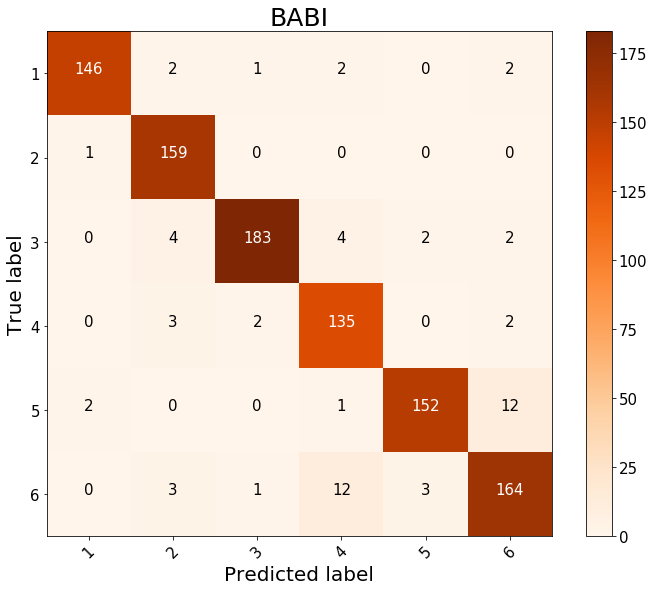

In [41]:
from sklearn.metrics import confusion_matrix # 混合行列
actual = answers_test # np.argmax(y_test, axis=1)
cm = confusion_matrix(pred_classes, actual)

classes = ['1','2','3','4','5','6'] # vocab # ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cm, classes=classes, title='BABI')
plt.show()
